In [1]:
# !pip install pretrainedmodels

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch.nn.functional as F
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
#import pretrainedmodels
import os
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import numpy as np
import pandas as pd
import os
import datetime as dt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

import pretrainedmodels
from sklearn.model_selection import KFold 

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek # doctest: +NORMALIZE_WHITESPACE
from imblearn.over_sampling import SMOTE

torch.cuda.get_device_name(0)

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


Using TensorFlow backend.


'Tesla P100-PCIE-16GB'

In [2]:
# print('Train set:')
# for cls in os.listdir("../input/ammi-2020-convnets/train/train"):
#     print('{}:{}'.format(cls, len(os.listdir(os.path.join("../input/ammi-2020-convnets/train/train", cls)))))
# im = Image.open('../input/ammi-2020-convnets/train/train/cgm/train-cgm-738.jpg')
# print(im.size)

In [3]:
data_path = "./data/train/train"
test_path = "./data/test/test"
extraimage_path = "./data/extraimages/extraimages"

In [4]:
print('Train set:')
class_distrbution = {}
for cls in os.listdir(data_path):
    print('{}:{}'.format(cls, len(os.listdir(os.path.join(data_path, cls)))))
    class_distrbution[cls] =  len(os.listdir(os.path.join(data_path, cls)))
im = Image.open(data_path+'/cgm/train-cgm-738.jpg')
print(im.size)
class_distrbution

Train set:
cbb:466
healthy:316
cbsd:1443
cmd:2658
cgm:773
(500, 500)


{'cbb': 466, 'cbsd': 1443, 'cgm': 773, 'cmd': 2658, 'healthy': 316}

# Distribution of the classes in the initial dataset

In [5]:
# Transformations for both the training and testing data

# Transformations for both the training and testing data
mean=[0.4543, 0.5137, 0.3240]
std=[0.1949, 0.1977, 0.1661]


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224), #448, 299, 224, 331
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean,std=std)])

test_transforms = transforms.Compose([ transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

In [6]:
class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        class_names = {}
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])

                name = str(i)+'-'+className
                if name not in class_names:
                    class_names[name] = 1
                else:
                    class_names[name] += 1
        self.file_list = files
#         print(class_names)
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        
# #         return im.view(3, 448, 448), classCategory
        return im.view(3, 224, 224), classCategory
# #         return im.view(3, 299, 299), classCategory

In [7]:
train_data = CassavaDataset(data_path, transform=train_transforms)

test_data = CassavaDataset(test_path, transform=test_transforms)

extraimage_data = CassavaDataset(extraimage_path, transform=train_transforms) #maybe need an other trasforms, I had to change the dataset structure :)

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = 0.2
shuffle_dataset = True
random_seed= 42 #42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [9]:
# # # Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

batch_size = 32

train_loader_origin = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             sampler=train_sampler)

valid_loader_origin = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             sampler=valid_sampler)

# # unlabeled_loader = torch.utils.data.DataLoader(extraimage_data, batch_size=batch_size) # to make batch_size work, I had to moove all the unlabeled data in a 0 folder

# # test_loader = torch.utils.data.DataLoader(test_data, batch_size=1) # make batch = 1 here 

In [10]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16

train_data = datasets.ImageFolder(data_path, transform=train_transforms)
test_data = datasets.ImageFolder(test_path, transform=test_transforms)
extraimage_data = datasets.ImageFolder(extraimage_path, transform=train_transforms)

train_loader_org = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader_org = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

unlabeled_loader_org = torch.utils.data.DataLoader(extraimage_data, batch_size=batch_size,
                                               num_workers=num_workers) # to make batch_size work, I had to moove all the unlabeled data in a 0 folder

In [11]:
# total_train = 0
# from collections import Counter

# Classes = Counter()

# for i, (data, label) in enumerate(train_loader):
#     total_train += i
#     Classes.update(label.tolist())# += 1 

In [12]:
# batch_size = train_data.__len__()

In [12]:
batch_size

5656

In [13]:
# # Classes
# np.set_printoptions(precision=6)
# # torch.set_printoptions(precision=6)
# torch.set_printoptions(precision=6)

In [15]:
def tensor_to_2d_numpy(dataset):
    np.set_printoptions(precision=6)
    torch.set_printoptions(precision=6)
    
    batch_size = dataset.__len__() # to take the full data
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    for (X_hat, y_hat) in train_loader:
        X = X_hat.view(batch_size, -1)
        X = X.numpy()
        y = y_hat.numpy()
    return X, y

In [16]:
X, y = tensor_to_2d_numpy(train_data)

In [17]:
X.shape

(5656, 150528)

In [18]:
y.shape

(5656,)

In [17]:
# !pip install -U imbalanced-learn


In [25]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 2658, 2: 1443, 4: 773, 3: 466, 1: 316})


In [26]:
smt = SMOTE(random_state=42)

In [27]:
X.shape

(5656, 150528)

In [28]:
y.shape

(5656,)

In [29]:
X_res, y_res = smt.fit_resample(X, y)

In [30]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 2658, 1: 2658, 2: 2658, 3: 2658, 4: 2658})


In [31]:
X_res.shape

(13290, 150528)

In [32]:
y_res.shape

(13290,)

In [33]:
def from_2d_numpy_back_to_tensor(X, y, img_size = 224):
    np.set_printoptions(precision=6)
    torch.set_printoptions(precision=6)
    
    X_hat = torch.from_numpy(X)
    
    y_hat = torch.from_numpy(y)
    
    X_hat = X_hat.view(X.shape[0], 3, 224, -1)

#     batch_size = dataset.__len__() # to take the full data
    
#     train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    
#     for (X_hat, y_hat) in train_loader:
#         X = X_hat.view(batch_size, -1)
#         X = X.numpy()
#         y = y_hat.numpy()
    return X_hat, y_hat

In [34]:
X_torch, y_torch = from_2d_numpy_back_to_tensor(X, y, img_size = 224)

In [35]:
X_torch.shape

torch.Size([5656, 3, 224, 224])

In [36]:
y_torch.shape

torch.Size([5656])

In [37]:
# tensor_x = torch.Tensor(my_x) # transform to torch tensor
# tensor_y = torch.Tensor(my_y)

num_workers = 2
# how many samples per batch to load
batch_size = 16

my_dataset = torch.utils.data.TensorDataset(X_torch, y_torch) # create your datset

train_loader = torch.utils.data.DataLoader(my_dataset, batch_size = batch_size)

In [42]:
# mean=[0.4543, 0.5137, 0.3240]
# std=[0.1949, 0.1977, 0.1661]

# inv_normalize = transforms.Normalize(
#    mean=[-0.4543/0.1949, -0.5137/0.1977, -0.3240/0.1661],
#    std=[1/0.1949, 1/0.1977, 1/0.1661]
# )

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std=[1/s for s in std]
)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = inv_normalize(img)# / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.figure(figsize=(20,20))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


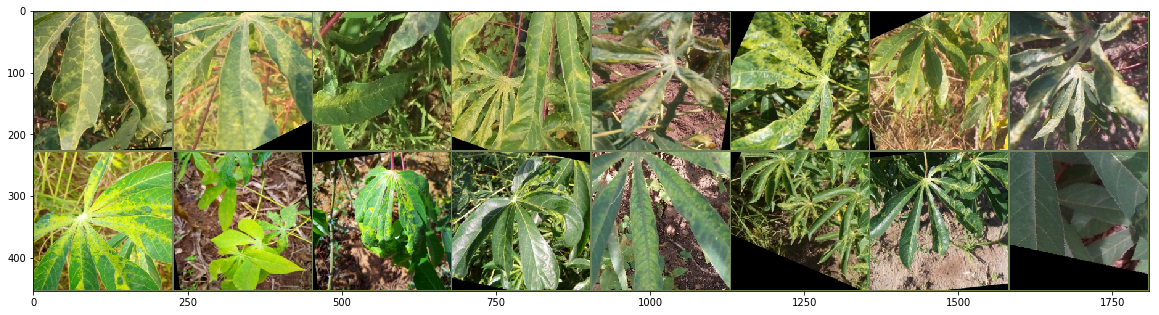

In [43]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

# Over sample minority class and under sample majority class (SMOTE)

In [10]:
class Model(nn.Module):
    
    def __init__(self,input,n_class , dropout=0.2):
        super(Model,self).__init__()
        
        self.conv=nn.Sequential(nn.Conv2d(input,32,5),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.MaxPool2d(3),
                                nn.Conv2d(32,64,3),
                                nn.ReLU(),
                                nn.BatchNorm2d(64),
                                nn.MaxPool2d(3),
                                nn.Conv2d(64,128,3),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
                                nn.MaxPool2d(3)
                               )
        
        self.fc1=nn.Linear(7*7*128,512)
        self.dropout =nn.Dropout(dropout)
        
        self.fc2=nn.Linear(512,1024)
        
        self.fc3=nn.Linear(1024,256)
        
        self.fc4=nn.Linear(256,n_class)
        
        
        
    def forward(self,x):
        x=self.conv(x)        
        x=x.view(x.size(0),-1)
        x=self.fc1(x)
        x=self.dropout(F.relu(x))
        x=self.fc2(x)
        x=self.dropout(F.relu(x))
        x=self.fc3(x)
        x=self.dropout(F.relu(x))
        x=self.fc4(x)        
        
        return x

In [11]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

 # Model whith cross entropy loss

In [12]:
train_loader_org

NameError: name 'train_loader_org' is not defined

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader_origin.dataset.classes,
class_weights = [class_distrbution[i] for i in train_loader_origin.dataset.classes]
class_weights_normalized = [max(class_weights)/i for i in class_weights]

class_weights_normalized,torch.Tensor(class_weights_normalized)

x = torch.Tensor(class_weights_normalized)
x = x.to(device)
x = x
x,class_distrbution

(tensor([5.7039, 8.4114, 1.8420, 1.0000, 3.4386], device='cuda:0'),
 {'cbb': 466, 'cbsd': 1443, 'cgm': 773, 'cmd': 2658, 'healthy': 316})

In [15]:
train_loader_origin.dataset.classes

['cbb', 'healthy', 'cbsd', 'cmd', 'cgm']

In [47]:
x = torch.tensor([5.7039, 1.8420, 3.4386, 1.0000, 8.4114], device='cuda:0') # got manually from Cross validation notebook 

In [48]:
# criterion = nn.CrossEntropyLoss(weight = x)
['cmd', 'healthy', 'cbsd', 'cbb', 'cgm']

tensor([5.703900, 1.842000, 3.438600, 1.000000, 8.411400], device='cuda:0')

In [12]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [13]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [14]:
# x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(input=3, n_class=5)
model=model.to(device)
lr = 1e-4  # 0.001
# model

#---------------------------------------------

lr = 2e-4 # 0.001
# criterion = nn.CrossEntropyLoss(weight = x)
criterion = nn.CrossEntropyLoss()

# criterion2 = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr)


epoch_num = 100
best_val_acc = 0.89
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader_origin, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(valid_loader_origin, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), model_name+'non_freeze_'+str(best_val_acc)[:4]+'.ckpt')
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 142], [train loss 1.23993], [train acc 0.54812]
------------------------------------------------------------
[epoch 1], [val loss 1.11400], [val acc 0.61395]
------------------------------------------------------------
[epoch 2], [iter 100 / 142], [train loss 1.09786], [train acc 0.60562]
------------------------------------------------------------
[epoch 2], [val loss 1.05377], [val acc 0.61411]
------------------------------------------------------------


In [88]:
# with class weight
loss_val, acc_val = validate(train_loader_org, model, criterion, optimizer, epoch)

------------------------------------------------------------
[epoch 100], [val loss 15.37985], [val acc 0.05597]
------------------------------------------------------------


In [85]:
loss_val, acc_val = validate(train_loader_org, model, criterion, optimizer, epoch)

------------------------------------------------------------
[epoch 100], [val loss 8.91854], [val acc 0.08651]
------------------------------------------------------------


#  Model with focal loss

In [90]:
def focalLoss(outputs, targets, w, alpha=1, gamma=4):
    ce_loss = torch.nn.functional.cross_entropy(outputs, targets, reduction='none') # important to add reduction='none' to keep per-batch-item loss
    pt = torch.exp(-ce_loss)
    focal_loss = (alpha * (1-pt)**gamma * ce_loss).mean() # mean over the batch
    return focal_loss


class FocalLoss(nn.Module):
    
    def __init__(self, weight=None, 
                 gamma=2., reduction='none'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob, 
            target_tensor, 
            weight=self.weight,
            reduction = self.reduction
        )

In [92]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels, x)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [93]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels, x).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(3,5)
model=model.to(device)
lr = 1e-4  # 0.001
# model

#---------------------------------------------

lr = 2e-4 # 0.001
criterion = focalLoss
# criterion = nn.CrossEntropyLoss()

# criterion2 = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr)


epoch_num = 100
best_val_acc = 0.89
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    
    if epoch == 49:
        loss_val, acc_val = validate(train_loader_org, model, criterion, optimizer, epoch)
        total_loss_val.append(loss_val)
        total_acc_val.append(acc_val)
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            torch.save(model.state_dict(), model_name+'non_freeze_'+str(best_val_acc)[:4]+'.ckpt')
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
            print('*****************************************************')

[epoch 1], [iter 100 / 354], [train loss 0.00689], [train acc 0.99125]
[epoch 1], [iter 200 / 354], [train loss 0.45434], [train acc 0.91812]
[epoch 1], [iter 300 / 354], [train loss 0.52662], [train acc 0.90583]
[epoch 2], [iter 100 / 354], [train loss 0.62261], [train acc 0.79625]
[epoch 2], [iter 200 / 354], [train loss 0.49490], [train acc 0.78969]
[epoch 2], [iter 300 / 354], [train loss 0.41239], [train acc 0.83292]
[epoch 3], [iter 100 / 354], [train loss 0.30750], [train acc 0.89250]
[epoch 3], [iter 200 / 354], [train loss 0.29858], [train acc 0.82188]
[epoch 3], [iter 300 / 354], [train loss 0.26761], [train acc 0.84833]
[epoch 4], [iter 100 / 354], [train loss 0.14436], [train acc 0.91750]
[epoch 4], [iter 200 / 354], [train loss 0.21943], [train acc 0.83531]
[epoch 4], [iter 300 / 354], [train loss 0.19581], [train acc 0.86750]
[epoch 5], [iter 100 / 354], [train loss 0.19738], [train acc 0.93312]
[epoch 5], [iter 200 / 354], [train loss 0.22607], [train acc 0.86062]
[epoch

In [96]:
loss_val, acc_val = validate(train_loader_org, model, criterion, optimizer, epoch)

------------------------------------------------------------
[epoch 100], [val loss 1.51993], [val acc 0.05703]
------------------------------------------------------------


In [95]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# #--------------------------------------------------------------------------------------#
# train_loader.dataset.classes,
# class_weights = [class_distrbution[i] for i in train_loader.dataset.classes]
# class_weights_normalized = [max(class_weights)/i for i in class_weights]

# class_weights_normalized,torch.Tensor(class_weights_normalized)

# x = torch.Tensor(class_weights_normalized)
# x = x.to(device)
# x = x
# x,class_distrbution

# #--------------------------------------------------------------------------------------#

# model = Model(input=3,n_class=5)

# model=model.to(device)

# lr = 1e-4   # 0.001

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

# num_epochs = 20
# total_loss_train, total_acc_train = [],[]


# # Train the model
# total_step = len(train_loader)

# for epoch in range(num_epochs):
   
#     train_loss = AverageMeter()
#     train_acc = AverageMeter()
#     val_loss = AverageMeter()
#     val_acc = AverageMeter()
#     curr_iter = (epoch - 1) * len(train_loader)

#     model.train()
#     n=0
#     loss_list = []
#     acc_list = []  
     
#     for i, data in enumerate(train_loader):
        
# #         correct=0
        
#         optimizer.zero_grad()
#         # Run the forward pass
#         images, labels = data
#         #print(images.size())

#         images = Variable(images).to(device)
#         labels = Variable(labels).to(device)   
        
#         outputs = model(images)
#         #print(outputs.size())
#         loss =  focalLoss(outputs, labels,x)
#         loss_list.append(loss.item())

#         # Backprop and perform Adam optimisation
#         loss.backward()
#         optimizer.step()

#         # Track the accuracy
#         total = labels.size(0)
#         #print(total)
#         prediction = outputs.max(1, keepdim=True)[1]
       
        
#         train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/total)
#         train_loss.update(loss.item())
#         curr_iter += 1
#         if (i + 1) % 100 == 0:
#             print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
#                 epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
#             total_loss_train.append(train_loss.avg)
#             total_acc_train.append(train_acc.avg)


# #########################################################################

#  model.eval()

# with torch.no_grad():
#     for i, data in enumerate(valid_loader):
#         images, labels = data
#         N = images.size(0)
#         images = Variable(images).to(device)
#         labels = Variable(labels).to(device)

#         outputs = model(images)
#         prediction = outputs.max(1, keepdim=True)[1]

#         val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

#         val_loss.update(focalLoss(outputs, labels,x).item())

#     print('------------------------------------------------------------')
#     print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
#     print('------------------------------------------------------------')            

# skorch


In [15]:
%matplotlib inline

from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import SGD
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits

from dataset import CassavaDataset #,CellsDataset, PatchedDataset
from model import Model#, UNet
# from utils import plot_cells, plot_masks, plot_mask_cells

torch.manual_seed(0);